In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/debertaxlarge/deberta-xlarge/config.json
/kaggle/input/debertaxlarge/deberta-xlarge/merges.txt
/kaggle/input/debertaxlarge/deberta-xlarge/README.md
/kaggle/input/debertaxlarge/deberta-xlarge/vocab.json
/kaggle/input/debertaxlarge/deberta-xlarge/tf_model.h5
/kaggle/input/debertaxlarge/deberta-xlarge/tokenizer_config.json
/kaggle/input/debertaxlarge/deberta-xlarge/bpe_encoder.bin
/kaggle/input/debertaxlarge/deberta-xlarge/pytorch_model.bin
/kaggle/input/debertaxlarge/deberta-xlarge/.gitattributes
/kaggle/input/debertaxlarge/deberta-xlarge/.git/config
/kaggle/input/debertaxlarge/deberta-xlarge/.git/packed-refs
/kaggle/input/debertaxlarge/deberta-xlarge/.git/HEAD
/kaggle/input/debertaxlarge/deberta-xlarge/.git/index
/kaggle/input/debertaxlarge/deberta-xlarge/.git/description
/kaggle/input/debertaxlarge/deberta-xlarge/.git/info/exclude
/kaggle/input/debertaxlarge/deberta-xlarge/.git/refs/heads/main
/kaggle/input/debertaxlarge/deberta-xlarge/.git/refs/remotes/origin/HEAD
/kaggl

Contents¶
1. Packages and Libraries

2. General Overview of Dataset

3. Cleaning Data

4. Corpus, Term Document Matrix, and Word Cloud

5. Variable: Location

6. Neural Network Model and Prediction

General Overview of Dataset

In [3]:
#Load Data, Preprocessing
train = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
train_len = len(train) 

all_data = pd.concat([train,test]) 

In [4]:
train.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [5]:
test.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [6]:
prompts = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
prompts

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [7]:
train['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

In [8]:
new_data = pd.read_csv('/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv')
new_data.head()
#在引入的数据库上进行训练,样本数比较多,label分布比较均衡

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [9]:
new_data.label.value_counts()

label
0    27371
1    17497
Name: count, dtype: int64

In [10]:
new_data.prompt_name.value_counts()

prompt_name
Distance learning                        5554
Seeking multiple opinions                5176
Car-free cities                          4717
Does the electoral college work?         4434
Facial action coding system              3084
Mandatory extracurricular activities     3077
Summer projects                          2701
Driverless cars                          2250
Exploring Venus                          2176
Cell phones at school                    2119
Grades for extracurricular activities    2116
Community service                        2092
"A Cowboy Who Rode the Waves"            1896
The Face on Mars                         1893
Phones and driving                       1583
Name: count, dtype: int64

In [11]:
#在该数据集中筛选题目给定的promptname
title = prompts['prompt_name']
new_train = new_data.iloc[:,0:2][new_data.prompt_name.isin(title)]
new_train



,text,label
1168,Cars have been around for awhile and they have...,0
1169,Have you ever thought what it would be like no...,0
1170,What you are about to read is going to give yo...,0
1171,cars have many flaws nd and in this day and ag...,0
1172,There are many advantages of limiting car usag...,0
...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1
44864,"Dear Senator,\n\nI am writing to you today to ...",1
44865,"Dear Senator,\n\nI am writing to you today to ...",1
44866,"Dear Senator,\n\nI am writing to you today to ...",1


In [12]:
#重新构建训练集
train_data = new_train.reset_index(drop=True)#修改索引值
train_data #0表示学生写的，1表示机器生成的

,text,label
0,Cars have been around for awhile and they have...,0
1,Have you ever thought what it would be like no...,0
2,What you are about to read is going to give yo...,0
3,cars have many flaws nd and in this day and ag...,0
4,There are many advantages of limiting car usag...,0
...,...,...
9146,"Dear Senator,\n\nI am writing to you today to ...",1
9147,"Dear Senator,\n\nI am writing to you today to ...",1
9148,"Dear Senator,\n\nI am writing to you today to ...",1
9149,"Dear Senator,\n\nI am writing to you today to ...",1


In [13]:
train_data.label.value_counts()


label
0    5380
1    3771
Name: count, dtype: int64

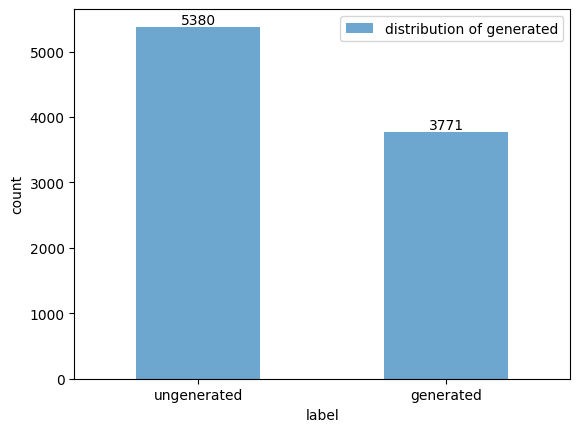

In [14]:
#绘制生成与否分布直方图
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
distribution = train_data.label.value_counts()

distribution.plot(kind='bar',label='distribution of generated',alpha=.65)
# 添加数据标签
for i, count in enumerate(distribution):
    ax.text(i, count, str(count), ha='center', va='bottom')# ha参数控制水平对齐方式, va控制垂直对齐方式
ax.set_xticklabels(["ungenerated","generated"], rotation=0)
ax.set_ylabel('count')
plt.legend(loc='best')

plt.show()

clean data

In [15]:
import re
import string

# Cleaning Functions
def remove_tag(text):
    tag = re.compile(r'@\S+')#匹配@之后的连续字符，`\S`匹配任何非空白字符（相当于 `[^ \t\n\r\f\v]`），`+` 表示前面的模式可以重复一次或多次。
    return tag.sub(r'',text)#使用sub函数用空串替换

def remove_URL(text):
    # http:... / https:... / www... #匹配网页链接
    url = re.compile(r'https?://\S+|www\.\S+')
    return re.sub(url,'',text)

def remove_html(text):#匹配特殊符号
    # < > / ( )
    html = re.compile(r'<[^>]+>|\([^)]+\)')
    return html.sub(r'',text)

def remove_punct(text):#替换标点符号
    # ['!','"','$','%','&',"'",'(',')','*',
    # '+',',','-','.','/',':',';','<','=',
    # '>','?','@','[','\\',']','^','_','`',
    # '{','|','}','~']
    punctuations = list(string.punctuation)
    table = str.maketrans('', '', ''.join(punctuations))#maketrans空字符串替换标点符号
    return text.translate(table)

In [16]:
train_data['text'][0]

'Cars have been around for awhile and they have had a major impact on society. Many people believe that there is no problem with the frequency of cars being driven. But, there are many advantages to less car use such as improving our cities and suburbs, improving safety, and decreasing pollution.\n\nMany have tried to make cities a little more dense and better for walking but nothing has seemed to work; therefore, they have moved on to suburbs. Now, people are trying to make suburbs better for getting around while walking instead of driving. By doing so, places such as shops will be made closer and more convienent which allows people to be able to consider walking as a better option. By having these suburbs, and soon hopefully cities, reduce the amount of cars used, the people living in these areas will be able to accomplish more in a healthier and safer way.\n\nSafety has been an issue in almost all areas due to a variety of reasons; one being cars. People pass by "Drive Safely" signs

In [17]:
#找到停用词和标点符号
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize #该函数用于将文本分割成单词（tokens）


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
train_data['cleaned'] = train_data['text'].apply(lambda x:remove_tag(x))
train_data['cleaned'] = train_data['cleaned'].apply(lambda x: remove_URL(x))
train_data['cleaned'] = train_data['cleaned'].apply(lambda x: remove_html(x))
train_data['cleaned'] = train_data['cleaned'].apply(lambda x: remove_punct(x))
train_data['cleaned'] = train_data['cleaned'].apply(lambda x: x.lower()) # lowering全部变成小写字母
train_data['cleaned'] = train_data['cleaned'].apply(lambda x: word_tokenize(x)) # split sentence into words list
# exclude stop words and make them a sentence again把停用词移除并连成一个句子
train_data['cleaned'] = train_data['cleaned'].apply(lambda x: ' '.join([word for word in x if word not in stop]))

In [19]:
train_data

,text,label,cleaned
0,Cars have been around for awhile and they have...,0,cars around awhile major impact society many p...
1,Have you ever thought what it would be like no...,0,ever thought would like pay gas everyday many ...
2,What you are about to read is going to give yo...,0,read going give insight advantages disadvantag...
3,cars have many flaws nd and in this day and ag...,0,cars many flaws nd day age trying get rid sime...
4,There are many advantages of limiting car usag...,0,many advantages limiting car usage limiting ca...
...,...,...,...
9146,"Dear Senator,\n\nI am writing to you today to ...",1,dear senator writing today express views elect...
9147,"Dear Senator,\n\nI am writing to you today to ...",1,dear senator writing today express support abo...
9148,"Dear Senator,\n\nI am writing to you today to ...",1,dear senator writing today express strong supp...
9149,"Dear Senator,\n\nI am writing to you today to ...",1,dear senator writing today express strong supp...


Ngram Exploration and wordcloud

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):#统计2元高频词元出现次数
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)#这两步合并为fit_transform函数，将文本中的词语转换为词频矩阵,矩阵元素a[i][j]表示j词在第i个文本下的词频，即各个词语出现的次数,
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()] #vocabulary_属性是一个字典，键是词语，值是词频矩阵的列索引，sum_words[0, idx]表示的是word的词频
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

`CountVectorizer` 将文本数据转换为词频矩阵，这个矩阵的每一行代表一个文档，每一列代表一个词汇表中的词。矩阵中的值表示该词在该文档中出现的次数。

<BarContainer object of 10 artists>

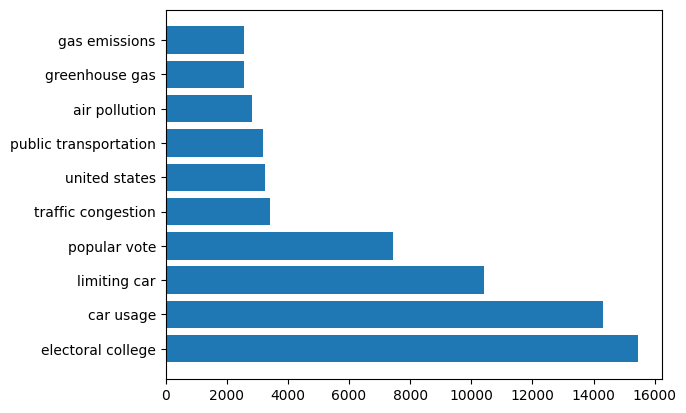

In [21]:
#AI-generated
top_n_bigrams=get_top_ngram(train_data[train_data['label'] == 1]['cleaned'],2)[:10] #2gram
x,y=map(list,zip(*top_n_bigrams))#（*）操作符用于解包上述生成的元组，map(funciton,iterable..)将function应用于iterable的元素，并返回一个迭代器
plt.barh(x,y)

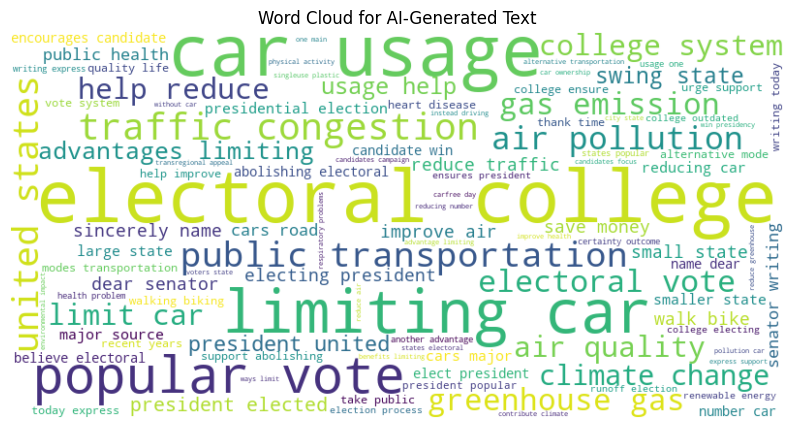

In [22]:
# Word Cloud for AI-Generated Text
from wordcloud import WordCloud
ai_generated_text = " ".join(train_data[train_data['label'] == 1]['cleaned'])
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(ai_generated_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')#imshow在图像中显示数组数据,采用双线性插值
plt.title('Word Cloud for AI-Generated Text')
plt.axis('off')#Turn off axis lines and labels
plt.show()

<BarContainer object of 10 artists>

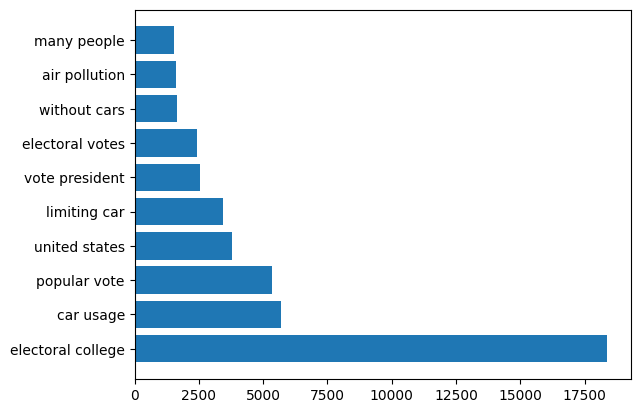

In [23]:
#Student
top_n_bigrams=get_top_ngram(train_data[train_data['label'] == 0]['cleaned'],2)[:10] #2gram
x,y=map(list,zip(*top_n_bigrams)) 
plt.barh(x,y)

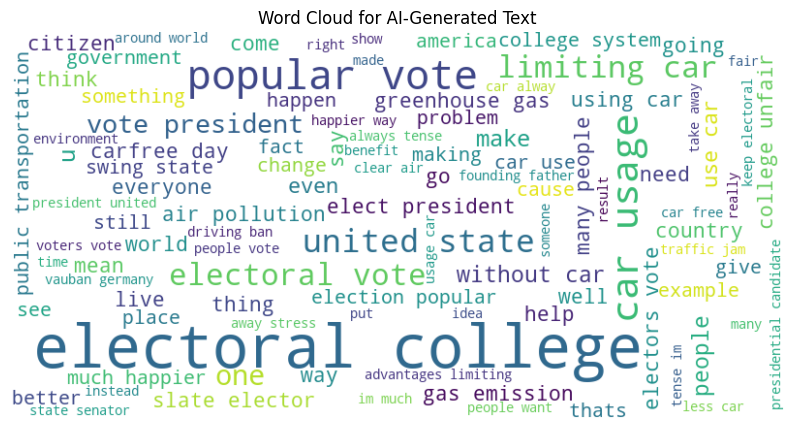

In [24]:
# Word Cloud for student Text
from wordcloud import WordCloud
ai_generated_text = " ".join(train_data[train_data['label'] == 0]['cleaned'])
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(ai_generated_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for AI-Generated Text')
plt.axis('off')
plt.show()

Dataset, DataLoader

In [25]:
from transformers import BertTokenizer
model_name = 'bert-large-uncased' # If possible, use "bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)#加载特定的预训练模型tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [26]:
from torch.utils.data import Dataset
import torch

#定义数据集
class LLMDataset(Dataset):
    def __init__(self,df,is_grad,tokenizer):
        self.df = df # Pandas.DataFrame
        self.is_grad = is_grad # True: train,valid / False: test
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df) # number of samples

    def __getitem__(self,idx):
        text = self.df.loc[idx,'cleaned'] # extracting text from each row
        
        encoded_dict = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,#自动在每个文本前后添加特殊标记(如CLS和SEP)
            padding='max_length',#补0
            truncation=True,#句子长度大于max_length时截断
            max_length=512, # given to the max_length of tokenized text
            return_tensors='pt', # PyTorch
            return_attention_mask=True, # We should put it into the model，计算注意力（attention）时忽略那些paddle值
        )

        if self.is_grad:#训练集
            labels = self.df.loc[idx]['label']
            # [batch,1,max_len(84)] -> [batch,max_len]#使用squeeze降维
            return {'input_ids':encoded_dict['input_ids'].squeeze(),
                    'attention_mask':encoded_dict['attention_mask'].squeeze(),
                    'token_type_ids':encoded_dict['token_type_ids'].squeeze(),
                   # Our loss_fn wants it to be a "float" type
                    'labels':torch.tensor(labels,dtype=torch.float).unsqueeze(dim=0)}
        else:#测试集
            # [batch,1,max_len(84)] -> [batch,max_len]
            return {'input_ids':encoded_dict['input_ids'].squeeze(),
                    'attention_mask':encoded_dict['attention_mask'].squeeze(),
                   'token_type_ids':encoded_dict['token_type_ids'].squeeze()}

tokenizer.encode_plus` 是一个用于将文本编码为模型可接受格式的函数。它通常会生成一个字典，包含以下几个键值对：

1. **`input_ids`**: 这是文本被编码后的 token ID 列表，表示输入文本的实际内容。

2. **`token_type_ids`**: 这是一个可选的列表，用于区分不同的句子（在 BERT 中用于区分句子 A 和句子 B）。

3. **`attention_mask`**: 这是一个可选的列表，通常用于指示哪些 token 是填充（padding）token，哪些是实际的输入 token。填充值为 0，实际输入值为 1。

In [27]:
train_df = train_data #方便后续train不动进行特征工程，不改动新建好的原始数据train_data
train_df

,text,label,cleaned
0,Cars have been around for awhile and they have...,0,cars around awhile major impact society many p...
1,Have you ever thought what it would be like no...,0,ever thought would like pay gas everyday many ...
2,What you are about to read is going to give yo...,0,read going give insight advantages disadvantag...
3,cars have many flaws nd and in this day and ag...,0,cars many flaws nd day age trying get rid sime...
4,There are many advantages of limiting car usag...,0,many advantages limiting car usage limiting ca...
...,...,...,...
9146,"Dear Senator,\n\nI am writing to you today to ...",1,dear senator writing today express views elect...
9147,"Dear Senator,\n\nI am writing to you today to ...",1,dear senator writing today express support abo...
9148,"Dear Senator,\n\nI am writing to you today to ...",1,dear senator writing today express strong supp...
9149,"Dear Senator,\n\nI am writing to you today to ...",1,dear senator writing today express strong supp...


In [28]:
#对测试集数据进行文本预处理
test['cleaned'] = test['text'].apply(lambda x:remove_tag(x))
test['cleaned'] = test['cleaned'].apply(lambda x: remove_URL(x))
test['cleaned'] = test['cleaned'].apply(lambda x: remove_html(x))
test['cleaned'] = test['cleaned'].apply(lambda x: remove_punct(x))
test['cleaned'] = test['cleaned'].apply(lambda x: x.lower()) # lowering全部变成小写字母
test['cleaned'] = test['cleaned'].apply(lambda x: word_tokenize(x)) # split sentence into words list
# exclude stop words and make them a sentence again把停用词移除并连成一个句子
test['cleaned'] = test['cleaned'].apply(lambda x: ' '.join([word for word in x if word not in stop]))



In [29]:
train_dataset = LLMDataset(train_df,True,tokenizer)
test_dataset = LLMDataset(test,False,tokenizer)

In [30]:
from torch.utils.data import random_split

train_size = int(0.8 * len(train_dataset)) # train:valid = 8:2
valid_size = len(train_dataset) - train_size

train_dataset,valid_dataset = random_split(train_dataset,[train_size,valid_size])
print(f'{len(train_dataset)} train samples')
print(f'{len(valid_dataset)} valid samples')
print(f'{len(test_dataset)} test samples')


7320 train samples
1831 valid samples
3 test samples


In [31]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset,batch_size=8,shuffle=True,pin_memory=True)#锁页内存(pin_memory)能够保持与GPU进行高速传输,在训练时加快数据的读取
valid_dataloader = DataLoader(valid_dataset,batch_size=8,shuffle=False,pin_memory=True)

#collate_fn用于自定义数据加载和批处理的方式


In [32]:
#生成测试集

test_dataloader = DataLoader(test_dataset,batch_size=8,shuffle=True,pin_memory=True)#锁页内存(pin_memory)能够保持与GPU进行高速传输,在训练时加快数据的读取



开始建模

In [33]:
import torch
import torch.nn as nn


In [34]:
configs = {
    'model_name':'bert-large-uncased',
    'num_labels':2,
    'batch_size':32,
    'epochs':4,
    'learning_rate':5e-6,
}

In [35]:
import numpy as np
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification

# Never Detach Tensor during forward
class LLMModel(nn.Module):
    '''
    To be honest, under the setting like this, there is no need to inherit.
    It's because I used "BertForSequenceClassification" which has final layer
    that is composed of "hidden size 2" for binary classification.

    So, you can think of this unnecessary inheritance is kind of "practice" for myself :)
    '''    
    def __init__(self,model_name):
        super().__init__()
        self.model = BertForSequenceClassification.from_pretrained(model_name)#from_pretrained方法会加载相应的预训练模型权重

    def forward(self,input_ids,attention_mask):
        output = self.model(input_ids=input_ids,attention_mask=attention_mask)
        logits = output.logits
        return logits
    #`logits` 是预训练bert的输出经过线性层的输出，通常用于二分类或多分类任务，通过softmax转换为概率

In [36]:
#检查gpu配置
if torch.cuda.is_available():
    device = 'cuda'
    print('GPU is running on..')
else: 
    device = 'cpu'
    print('CPU is running on..')

GPU is running on..


In [37]:
model = LLMModel(configs['model_name']).to(device)


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
# loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer
from transformers import AdamW

optimizer = AdamW(model.parameters(),
                lr=6e-6,
                eps=1e-8,
                no_deprecation_warning=True)

# metric for validation
# f1_score(y_label,y_pred)
from sklearn.metrics import f1_score

metric = f1_score

In [39]:
import gc,os
from tqdm.auto import tqdm # visualizing tool for progress

# They will be used to pick the best model.pt given to the valid loss
best_model_epoch, valid_loss_values = [],[] 
valid_loss_min = [1] # arbitrary loss I set here
def train(model,device,train_dataloader,valid_dataloader,epochs,loss_fn,optimizer,metric):

    for epoch in range(epochs):
        gc.collect() # memory cleaning垃圾回收机制，减少占用内存
        model.train()

        train_loss = 0
        train_step = 0
        pbar = tqdm(train_dataloader)#tqdm参数是一个iterable

        for batch in pbar: # you can also write like "for batch in tqdm(train_dataloader"
            optimizer.zero_grad() # initialize
            train_step += 1

            train_input_ids = batch['input_ids'].to(device)
            train_attention_mask = batch['attention_mask'].to(device)
            train_labels = batch['labels'].squeeze().to(device).long()#long()转化成一维张量
            
            # You can refer to the class "TweetsModel" for understand 
            # what would be logits
            logits = model(train_input_ids, train_attention_mask).to(device)
            predictions = torch.argmax(logits, dim=1) # get an index from larger one
            detached_predictions = predictions.detach().cpu().numpy()
            
            loss = loss_fn(logits, train_labels)
            loss.backward() 
            optimizer.step()
            model.zero_grad()

            train_loss += loss.detach().cpu().numpy().item()

            pbar.set_postfix({'train_loss':train_loss/train_step})#设置进度条显示信息
        pbar.close()

        with torch.no_grad():
            model.eval()

            valid_loss = 0
            valid_step = 0
            total_valid_score = 0

            y_pred = [] # for getting f1_score that is a metric of the competition
            y_true = []

            pbar = tqdm(valid_dataloader)
            for batch in pbar:
                valid_step += 1

                valid_input_ids = batch['input_ids'].to(device)
                valid_attention_mask = batch['attention_mask'].to(device)
                valid_labels = batch['labels'].squeeze().to(device).long()

                logits = model(valid_input_ids, valid_attention_mask).to(device)
                predictions = torch.argmax(logits, dim=1)
                detached_predictions = predictions.detach().cpu().numpy()
                
                loss = loss_fn(logits, valid_labels)
                valid_loss += loss.detach().cpu().numpy().item()

                y_pred.extend(predictions.cpu().numpy())
                y_true.extend(valid_labels.cpu().numpy())

            valid_loss /= valid_step
            f1 = f1_score(y_true,y_pred)

            print(f'Epoch [{epoch+1}/{epochs}] Score: {f1}')
            print(f'Epoch [{epoch+1}/{epochs}] Valid_loss: {valid_loss}')

            if valid_loss < min(valid_loss_min):
                print('model improved!')
            else:
                print('model not improved')
    
            torch.save(model.state_dict(), f'epoch:{epoch+1}_model.pt')#state_dict 是一个字典对象，包含了模型的所有可学习参数（如权重和偏置）及其当前值
            print('save checkpoint!')
            valid_loss_min.append(valid_loss)
            print(f'valid_loss_min:{min(valid_loss_min)}')

        best_model_epoch.append(f'/kaggle/working/epoch:{epoch+1}_model.pt')
        valid_loss_values.append(valid_loss)
        print('='*100)

    select_best_model() # refer to below function
    print('Train/Valid Completed!!')
    del train_dataloader, valid_dataloader # memory cleaning
    gc.collect()

def select_best_model():
    best_model = best_model_epoch[np.array(valid_loss_values).argmin()]
    os.rename(best_model, best_model.split('.pt')[0] + '_best.pt')#重命名文件

In [40]:
print(f'Before training, files in current directory: {os.listdir()}')#列出当前工作目录下的所有文件和子目录

Before training, files in current directory: ['.virtual_documents']


In [41]:
print('Training Start!')
print('=' * 100)

train(model,
    device,
    train_dataloader,
    valid_dataloader,
    configs['epochs'],
    loss_fn,
    optimizer,
    metric)

del model,train_dataloader, valid_dataloader
gc.collect()

Training Start!


  0%|          | 0/915 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

Epoch [1/4] Score: 0.9923664122137406
Epoch [1/4] Valid_loss: 0.0179609541514864
model improved!
save checkpoint!
valid_loss_min:0.0179609541514864


  0%|          | 0/915 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

Epoch [2/4] Score: 0.9916932907348243
Epoch [2/4] Valid_loss: 0.0361276092981273
model not improved
save checkpoint!
valid_loss_min:0.0179609541514864


  0%|          | 0/915 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

Epoch [3/4] Score: 0.9949302915082383
Epoch [3/4] Valid_loss: 0.02163618032541685
model not improved
save checkpoint!
valid_loss_min:0.0179609541514864


  0%|          | 0/915 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

Epoch [4/4] Score: 0.9961977186311787
Epoch [4/4] Valid_loss: 0.018120634680162447
model not improved
save checkpoint!
valid_loss_min:0.0179609541514864
Train/Valid Completed!!


30

In [42]:
def inference(model,test_dataloader):
    all_preds = []
    model.eval()

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            logits = model(input_ids,attention_mask)
            logits = logits.detach().cpu().numpy()
            all_preds.append(logits)
    
    return all_preds

In [53]:
# Pick up the model.pt written with the best
# which has the lowest validation loss through all Epochs.

for filename in os.listdir():
    if 'best.pt' in filename: 
        best_pt = filename
print(f'Best model.pt: {best_pt}')
check_point = torch.load(best_pt)

# We have to load a model again because I deleted after training/validation
model = LLMModel(configs['model_name']).to(device)
model.to(device)
model.load_state_dict(check_point)#将之前保存的模型参数加载到当前模型的实例中

predictions = inference(model,test_dataloader)

Best model.pt: epoch:1_model_best.pt


/tmp/ipykernel_30/1081960837.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(best_pt)
Some weights of BertForSequenceClassification were not ini

  0%|          | 0/1 [00:00<?, ?it/s]

In [47]:
sample = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')
sample

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


In [54]:
predictions

[array([[-1.6712935,  1.4148414],
        [-1.0083557,  0.8562799],
        [-1.1030409,  0.5321432]], dtype=float32)]

In [61]:
import torch.nn.functional as F
F.softmax(torch.tensor(predictions,dtype=torch.float32), dim=1)

tensor([[[0.2125, 0.5036],
         [0.4124, 0.2881],
         [0.3751, 0.2083]]])

predictions = np.argmax(predictions,axis=1) # 0 or 1
sample['generated'] = predictions
sample.head(10)

In [ ]:
sample.to_csv('submission.csv',index=False,header=True)